In [1]:
# ! pip install numpy pandas matplotlib seaborn plotly statsmodels scikit-learn lightgbm tensorflow keras-tuner

## **1. Import Necessary Modules**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import os
import warnings
from tqdm import tqdm

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import boxcox, yeojohnson

import lightgbm as lgb
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

warnings.filterwarnings("ignore")

2024-06-05 15:41:29.120961: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 15:41:29.121054: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 15:41:29.273336: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## **2. Load Data**

In [3]:
files = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        files.append(os.path.join(dirname, filename))
sample_submission, train, test = files

In [4]:
train_df = pd.read_csv(train, index_col='id')
train_df

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
id,,,,,,,,,,,,,,,,,,,,,
0,5,8,5,8,6,4,4,3,3,4,...,5,3,3,5,4,7,5,7,3,0.445
1,6,7,4,4,8,8,3,5,4,6,...,7,2,0,3,5,3,3,4,3,0.450
2,6,5,6,7,3,7,1,5,4,5,...,7,3,7,5,6,8,2,3,3,0.530
3,3,4,6,5,4,8,4,7,6,8,...,2,4,7,4,4,6,5,7,5,0.535
4,5,3,2,6,4,4,3,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117952,3,3,4,10,4,5,5,7,10,4,...,7,8,7,2,2,1,4,6,4,0.495
1117953,2,2,4,3,9,5,8,1,3,5,...,9,4,4,3,7,4,9,4,5,0.480
1117954,7,3,9,4,6,5,9,1,3,4,...,5,5,5,5,6,5,5,2,4,0.485


In [5]:
test_df = pd.read_csv(test)
test_df.drop('id', axis=1, inplace=True)
test_df

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors
0,4,6,3,5,6,7,8,7,8,4,8,5,7,5,6,3,6,4,4,5
1,4,4,2,9,5,5,4,7,5,4,2,4,7,4,5,1,7,4,4,3
2,1,3,6,5,7,2,4,6,4,2,7,9,2,5,5,2,3,6,8,3
3,2,4,4,6,4,5,4,3,4,4,7,8,4,6,7,6,4,2,4,4
4,6,3,2,4,6,4,5,5,3,7,4,3,2,6,4,6,8,4,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745300,5,4,8,3,5,4,4,5,5,5,5,6,1,3,5,6,4,4,6,6
745301,4,4,2,12,4,3,4,3,5,5,3,7,4,4,3,5,5,3,5,4
745302,5,7,9,5,5,6,7,5,5,3,6,11,3,11,4,5,9,5,5,4
745303,4,7,6,3,5,2,3,8,6,7,6,6,8,6,2,3,8,7,5,5


#### **There are `1117957` rows and `22` columns in train dataset and `745305` rows and `21` columns in test dataset. 1 (target=`FloodProbability`) column is dropped in testing dataset.**


In [6]:
train_df.shape, test_df.shape

((1117957, 21), (745305, 20))

## ***3. Data Inspection - All the features are in `int` and target column distribution is continuous in `float`***

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1117957 entries, 0 to 1117956
Data columns (total 21 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   MonsoonIntensity                 1117957 non-null  int64  
 1   TopographyDrainage               1117957 non-null  int64  
 2   RiverManagement                  1117957 non-null  int64  
 3   Deforestation                    1117957 non-null  int64  
 4   Urbanization                     1117957 non-null  int64  
 5   ClimateChange                    1117957 non-null  int64  
 6   DamsQuality                      1117957 non-null  int64  
 7   Siltation                        1117957 non-null  int64  
 8   AgriculturalPractices            1117957 non-null  int64  
 9   Encroachments                    1117957 non-null  int64  
 10  IneffectiveDisasterPreparedness  1117957 non-null  int64  
 11  DrainageSystems                  1117957 non-null  int6

### ***`Descriptive Statistics` - Brief Summary of Dataset***
* `Mean Value ~ 5` - Means & Median values are almost same which represents normal distribution.
* `Standard Deviation ~ 2` - Which means data has not much vairability and lies within 2 std.
* `Range ~ 0-8` - Data mostly lie between 0-8 which means there are some outliers.

In [8]:
summary = train_df.describe()
summary.loc['median'] = train_df.median()
summary.loc['skewness'] = train_df.skew()
summary

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
count,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,...,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06
mean,4.921450e+00,4.926671e+00,4.955322e+00,4.942240e+00,4.942517e+00,4.934093e+00,4.955878e+00,4.927791e+00,4.942619e+00,4.949230e+00,...,4.946893e+00,4.953999e+00,4.931376e+00,4.929032e+00,4.925907e+00,4.927520e+00,4.950859e+00,4.940587e+00,4.939004e+00,5.044803e-01
std,2.056387e+00,2.093879e+00,2.072186e+00,2.051689e+00,2.083391e+00,2.057742e+00,2.083063e+00,2.065992e+00,2.068545e+00,2.083324e+00,...,2.072333e+00,2.088899e+00,2.078287e+00,2.082395e+00,2.064813e+00,2.074176e+00,2.068696e+00,2.081123e+00,2.090350e+00,5.102610e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.850000e-01
25%,3.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,...,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.700000e-01
50%,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,...,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.050000e-01
75%,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,...,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,5.400000e-01
max,1.600000e+01,1.800000e+01,1.600000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.600000e+01,1.800000e+01,...,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.700000e+01,1.800000e+01,1.900000e+01,1.600000e+01,1.600000e+01,7.250000e-01
median,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,...,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.050000e-01
skewness,4.445283e-01,4.587283e-01,4.264912e-01,4.343141e-01,4.421678e-01,4.294031e-01,4.414024e-01,4.492480e-01,4.211445e-01,4.635508e-01,...,4.414200e-01,4.399167e-01,4.250985e-01,4.504879e-01,4.441674e-01,4.514145e-01,4.370453e-01,4.551365e-01,4.375608e-01,4.722559e-02


### ***Missing Values - There are `NO` missing values in the dataset.***

In [9]:
train_df.isna().sum()

MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64

### ***`Duplicate Values` - There are `NO` duplicate values in the dataset.***

In [10]:
train_df.duplicated().sum()

0

In [11]:
target_train_df = train_df['FloodProbability']
train_df.drop('FloodProbability', axis=1, inplace=True)

## ***4. EDA - Let's Visualize the data to get insights***

### ***Mostly features are normally distributed, but there are some outliers, which is represented by `kdeplot` showing slight right skew. For better visualization and understanding of outliers, see `Boxplot` results***

(array([-15., -10.,  -5.,   0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.]),
 [Text(-15.0, 0, '−15'),
  Text(-10.0, 0, '−10'),
  Text(-5.0, 0, '−5'),
  Text(0.0, 0, '0'),
  Text(5.0, 0, '5'),
  Text(10.0, 0, '10'),
  Text(15.0, 0, '15'),
  Text(20.0, 0, '20'),
  Text(25.0, 0, '25'),
  Text(30.0, 0, '30'),
  Text(35.0, 0, '35')])

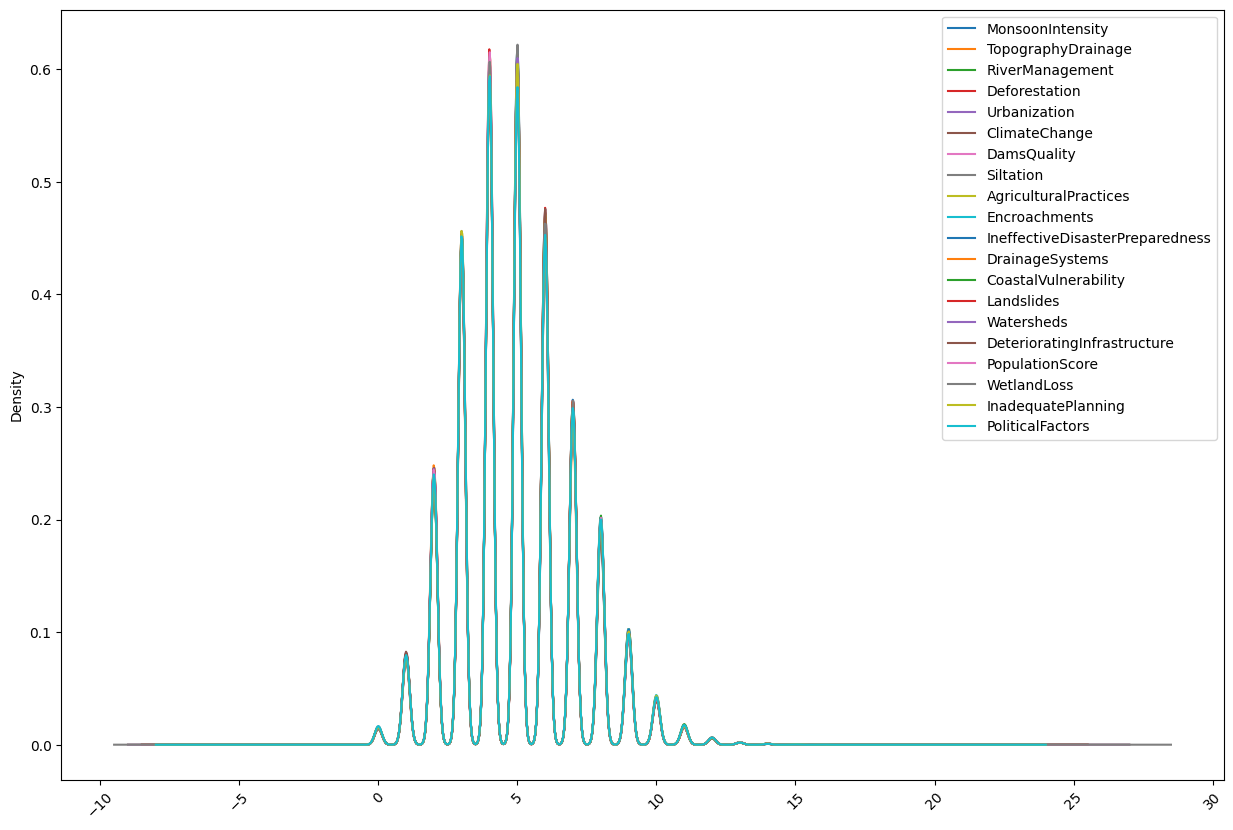

In [12]:
# Visualize the Distribution (spread) of all features except Target

train_df.plot(kind='kde', figsize=(15, 10))
plt.tight_layout()

<Axes: ylabel='Density'>

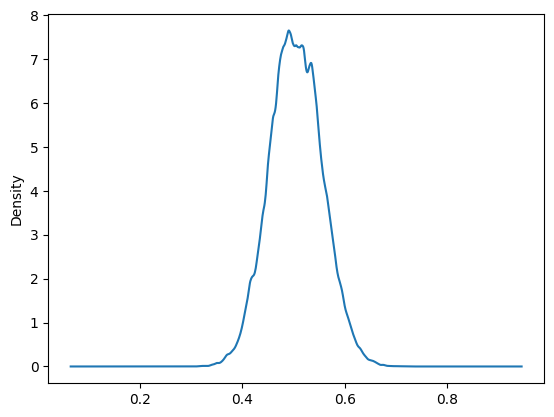

In [13]:
# Visualize the Distribution (spread) of Target feature `Flood Probability`

target_train_df.plot(kind='kde')
plt.title('Distribution Plot of Flood Probability')
plt.tight_layout()

### ***`Boxplot` - For better understanding of outliers***

* All the plots are clearly representing the skewness of data towards right.

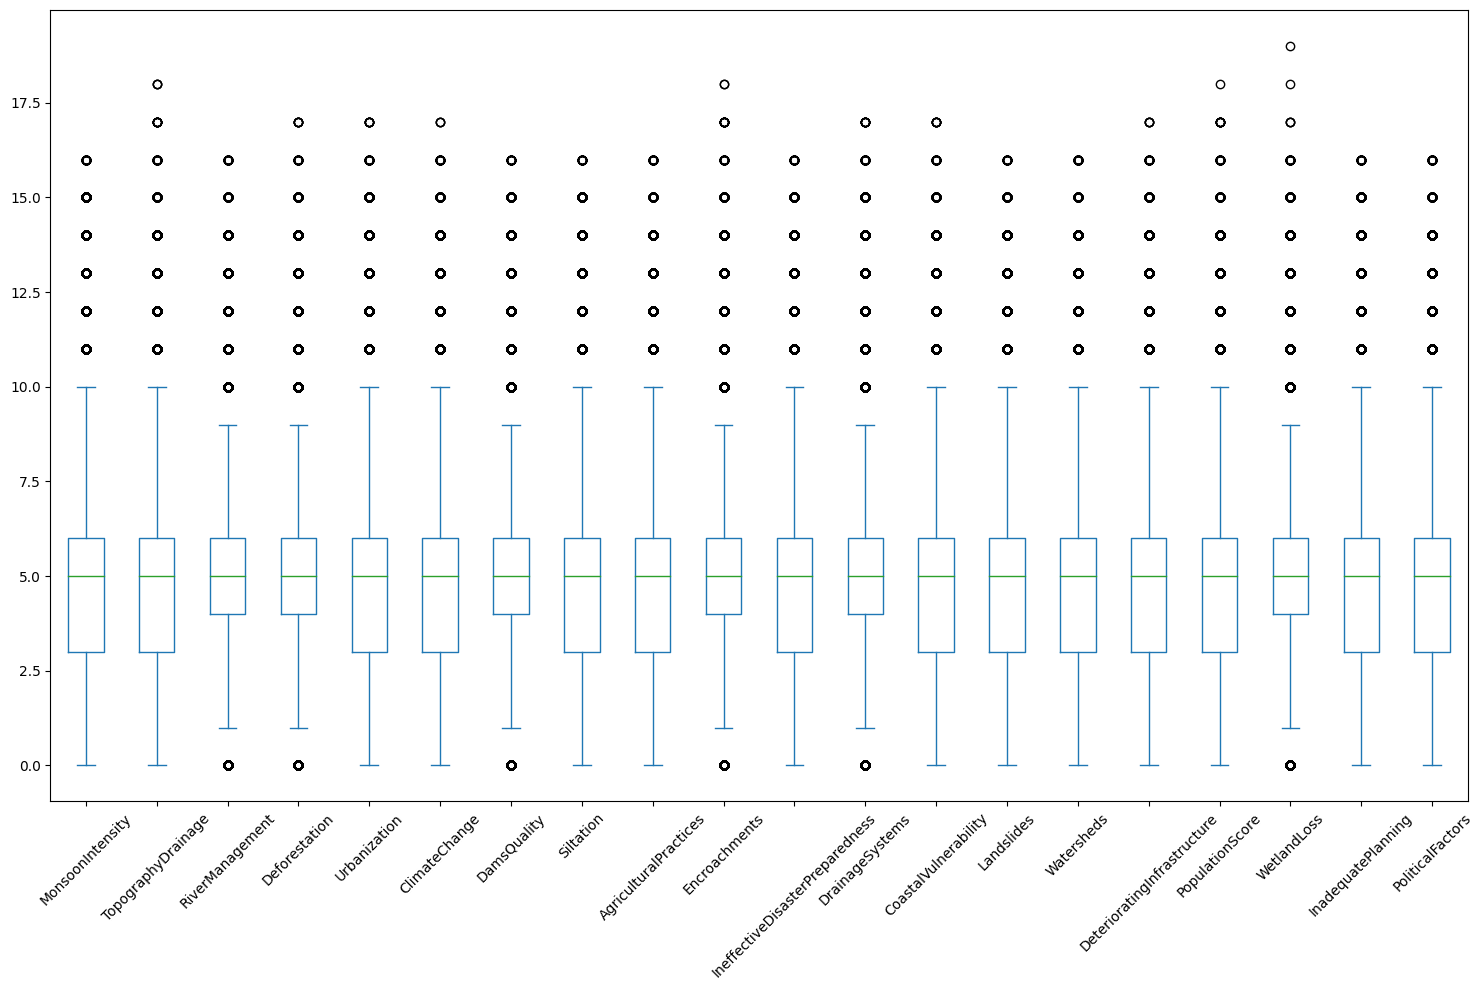

In [14]:
# Visualize the Boxplot of all features except Target

train_df.plot(kind='box', figsize=(15, 10))
plt.xticks(rotation=45)
plt.tight_layout()

#### ***`FloodProbability` - Target Feature contains outliers - it is skewed on both sides***

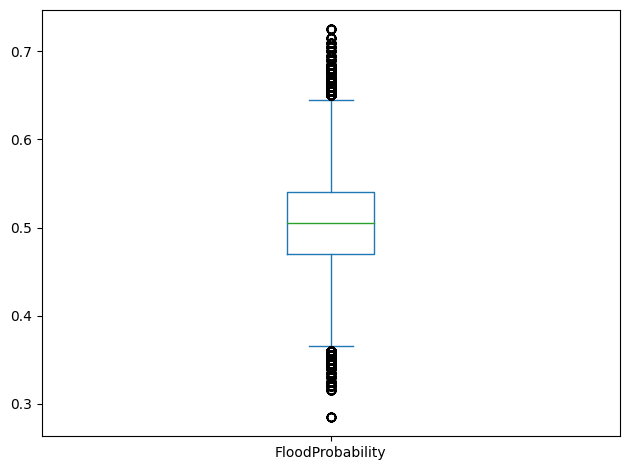

In [15]:
# Visualize the Boxplot of Target feature `Flood Probability`

target_train_df.plot(kind='box')
plt.tight_layout()

### ***`Correlation Matrix` - Dependency of Columns to other features.***

Text(0.5, 1.0, 'Correlation Matrix')

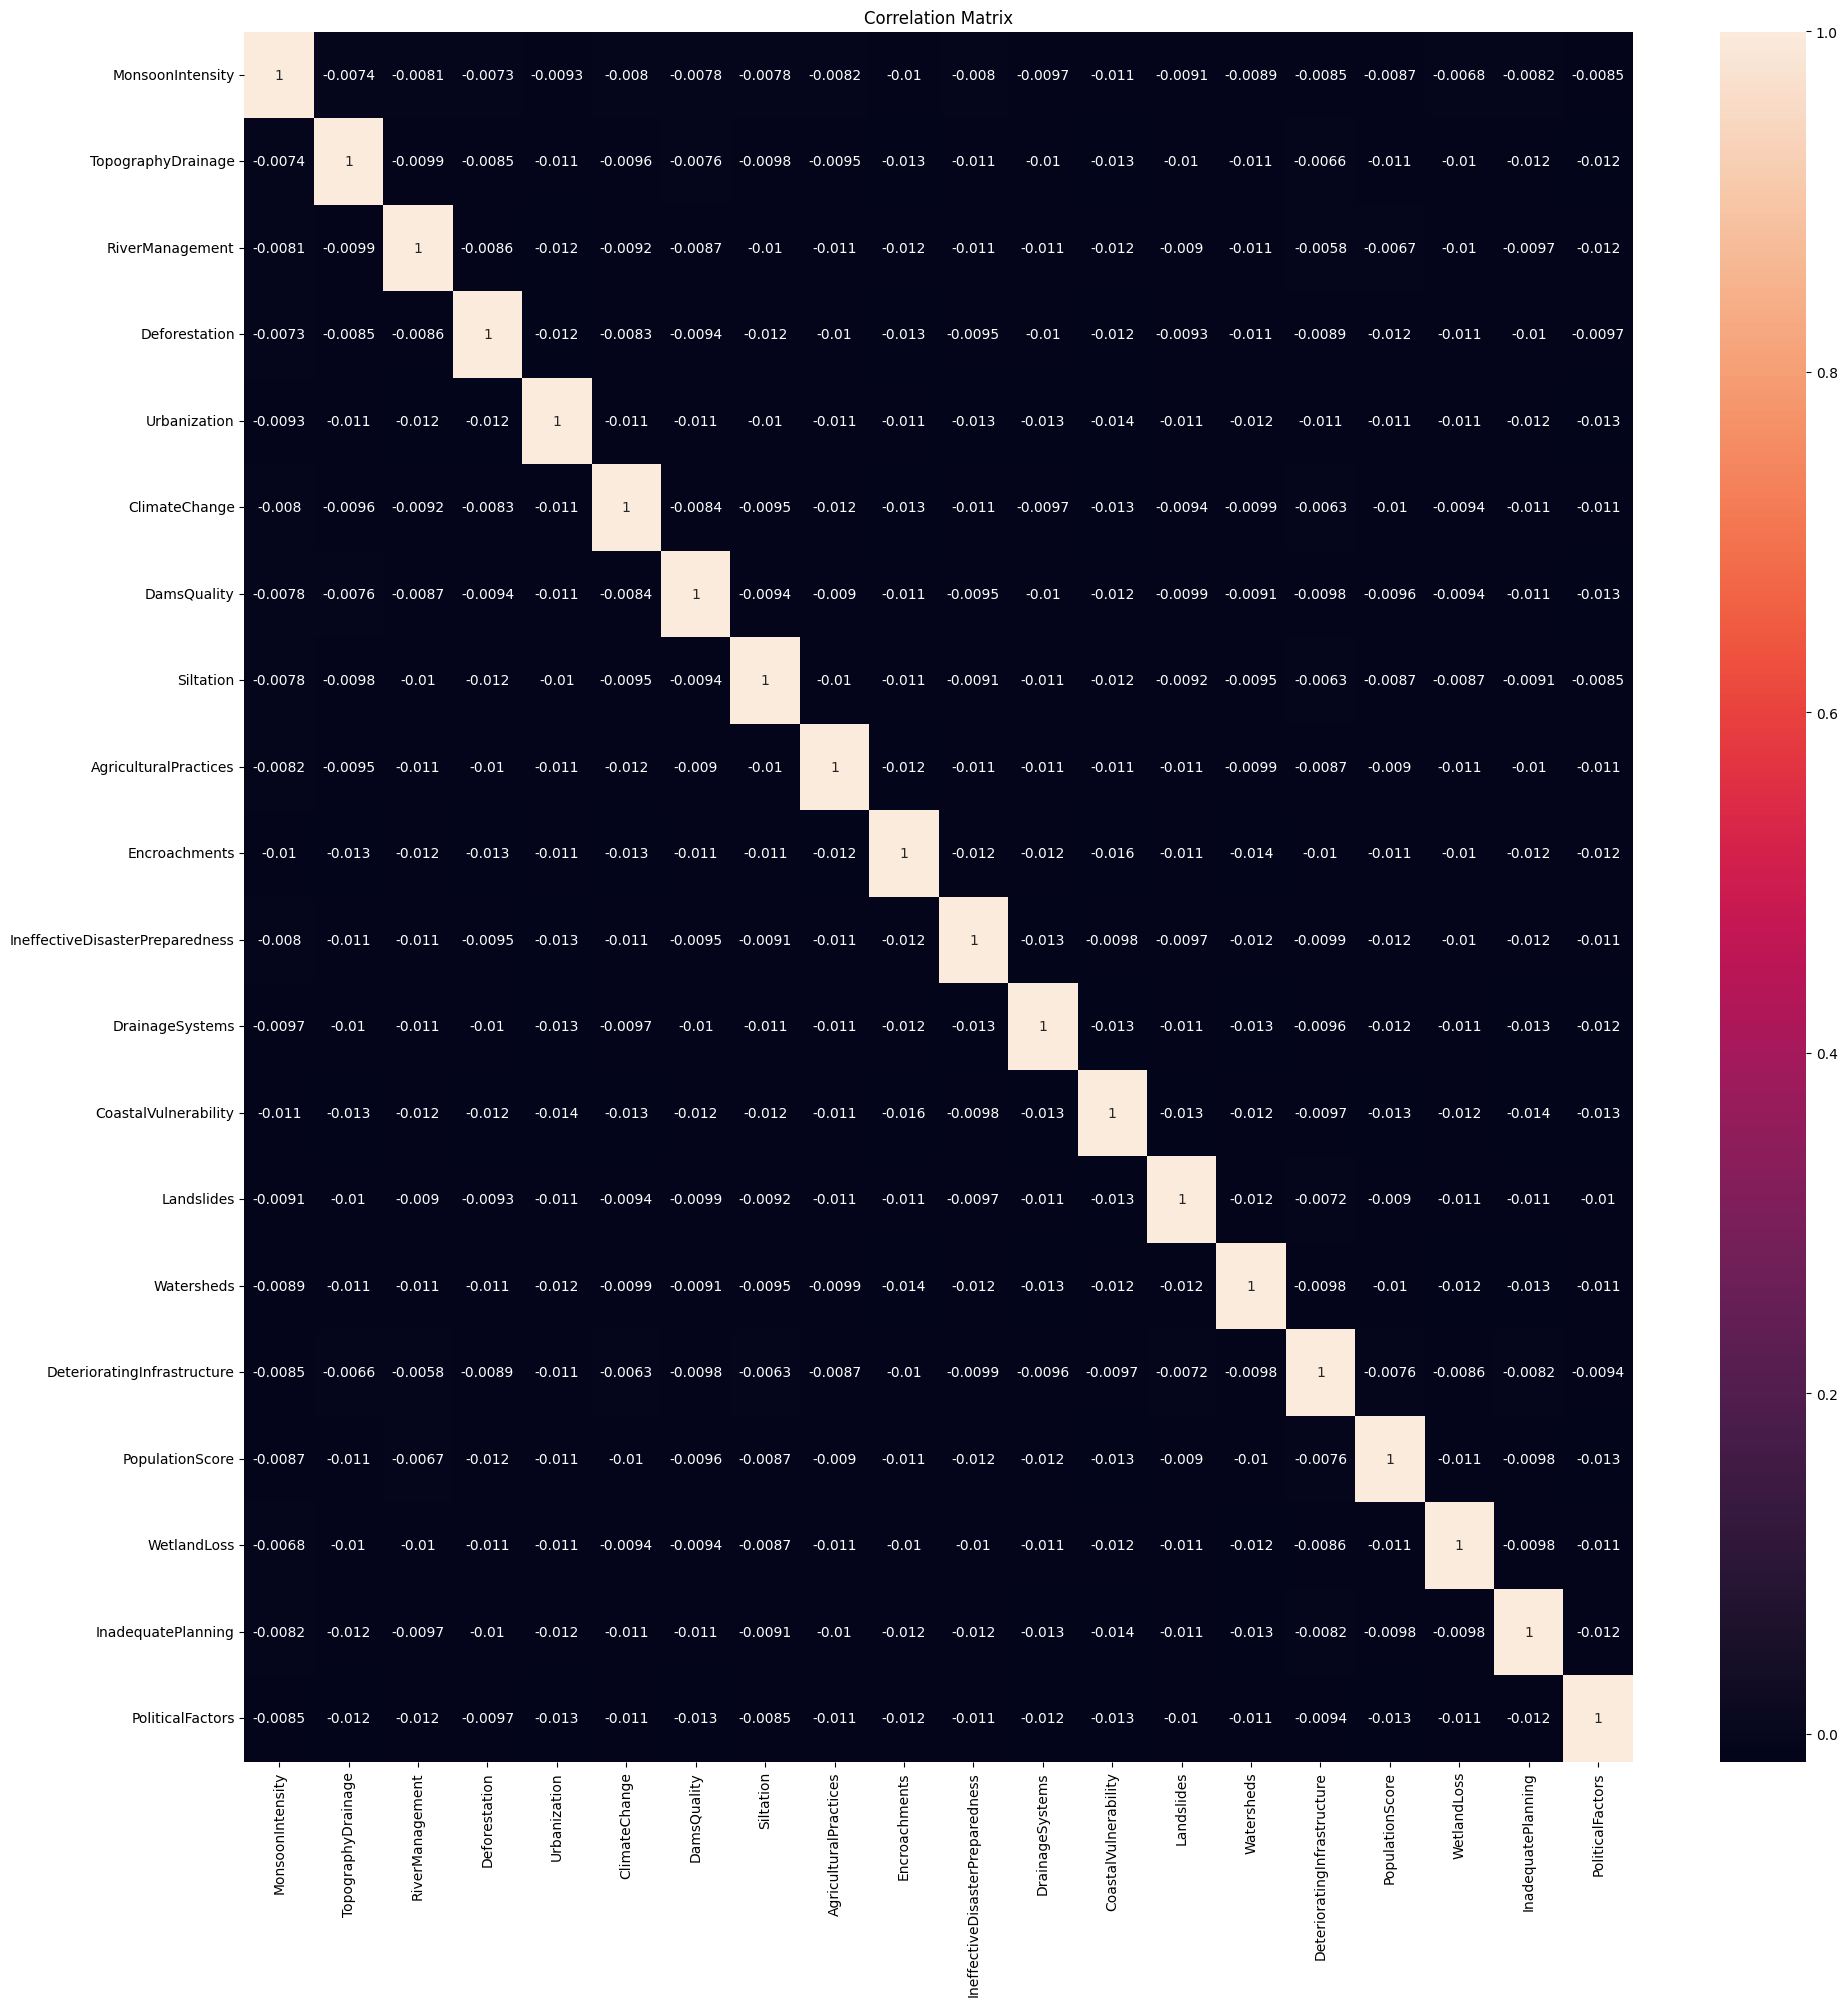

In [16]:
plt.figure(figsize=(20, 20))
sns.heatmap(train_df.corr(), annot=True)
plt.tight_layout()
plt.title('Correlation Matrix')

### ***Chech for Multicollinearity - There is no multicollinearity in the dataset.***
#### ***1. VIF - Variance Inflation Factor (VIF)***
* A VIF between 1 and 5 indicates low to moderate multicollinearity.
* A VIF above 5 (or more conservatively, above 10) suggests high multicollinearity, which might be problematic.

In [17]:
X = train_df.select_dtypes(include=[np.number])
X = sm.add_constant(X)

vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,Variable,VIF
0,const,142.456543
1,MonsoonIntensity,1.001718
2,TopographyDrainage,1.002464
3,RiverManagement,1.002344
4,Deforestation,1.002477
5,Urbanization,1.003128
6,ClimateChange,1.002400
7,DamsQuality,1.002310
8,Siltation,1.002158
9,AgriculturalPractices,1.002531


#### ***2. PCA - Principal Component Analysis - Explained Variance Ratio (EVR)***

The PCA results suggest that there is no single dominant component explaining most of the variance, and the variance is distributed relatively evenly across the components. This pattern is indicative of low to moderate multicollinearity among the original variables

* Optimal Features for 95% Explained Variance = 20
* Optimal Features for 99% Explained Variance = 18

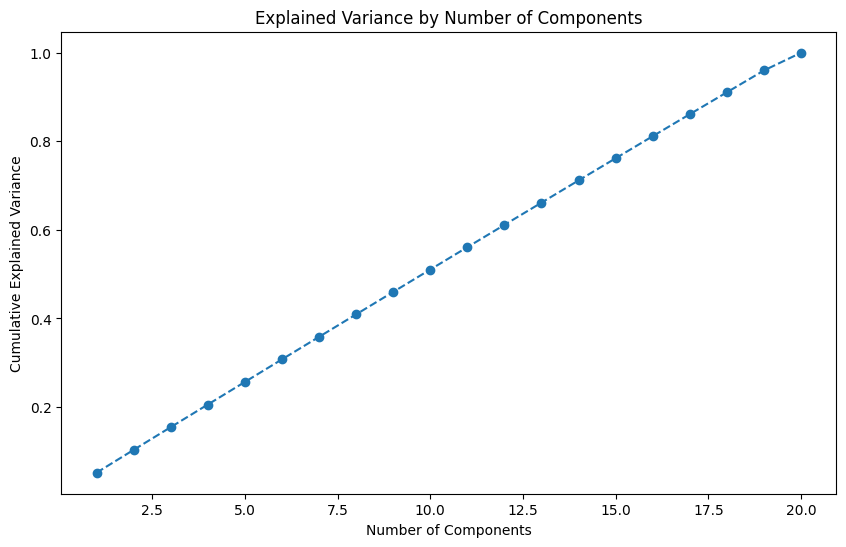

In [18]:
X = train_df.select_dtypes(include=[np.number])

pca = PCA()
pca.fit(X)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.savefig('pca.png')

## **5. Feature Engineering - Lets Explore the Features**

### ***1. Feature Scaling***
* StandardScaler - Standardize features by removing the mean and scaling to unit variance
* MinMaxScaler - Scale features to a given range
* RobustScaler - Scale features using statistics that are robust to outliers

In our dataset, we have some features that are right skewed - showcasing some outliers in them.
So, we use RobustScaler instead.

In [19]:
# Robust Scaler - Robust to outliers

scaler = RobustScaler()
scaled = pd.DataFrame(scaler.fit_transform(train_df), columns=train_df.columns)

#### **Let Visualize, what Robust Scaling did with the dataset, either skewness in data reduced / diminished or not ?**
But below Distribution plot is still representing same level of skewness in dataset as before present in datset before applying scaling.

In [ ]:
for col in scaled:
    sns.kdeplot(scaled[col])
    plt.title(f'KDE Plot of {col}')
    plt.show()
    plt.tight_layout()

In [ ]:
scaled.agg(['skew']).T

#### ***Robust Scaler didn't wokrked well, so the best practice to scale the data using `StandardScaler()`***

In [ ]:
scaler = StandardScaler()
train_scaled = pd.DataFrame(scaler.fit_transform(train_df), columns=train_df.columns)
test_scaled = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)

### ***2. Featuere Transformation***

Feature transformation is an important step in data preprocessing, particularly when dealing with skewed data. Skewed data can affect the performance of many machine learning algorithms, so it's often beneficial to transform these features to approximate a normal distribution.
* Log Transformation - `−log(x)` Effective when have long tail.
* (sq, cube) Root Transformation - `√(x)` & `∛(x)` Useful for right skewed data but (ensure data should be +ve)
* Box-Cox Transformation - `y=[x^(𝜆)-1] / 𝜆](for λ ≠ 0), y=[log(x)](for λ=0)` Flexible and can handle different types of skewness.
* Reciprocal Transformation - `y=(1/x)` Useful for highly skewed data but can be applied on non-zero data

#### ***Some Columns Contain -ve values init, lets check if not, then we can go for any otherwise have to choose the transformation wisely***

In [ ]:
for col in train_scaled.columns:
    if (train_scaled[col] < 0).any():
        print(f"Column '{col}' has negative values.")

#### ***`Yeo-Johnson Transformation` - Extension of Box-Cox transformation that can handle any type of skewed data.***
As many of the columns have -ve values in it so, we cannot use simple `LogTransformation` we can use `Log with shift` transformation, or can use
`Yeo-Johnson Transformation`

<img src="yeo_johnson.png" alt="Yeo Johnson Algorithm">

In [ ]:
def apply_yeojohnson(column):
    transformed, _ = yeojohnson(column)
    return transformed

yeo_transformed = train_scaled.apply(apply_yeojohnson)
yeo_transformed

##### ***This Transformation again not worked well, because this skewness is its intrinsic behavior which will not affect on the overall data***

In [ ]:
for col in yeo_transformed:
    sns.kdeplot(yeo_transformed[col])
    plt.title(f'KdePlot of {col}')
    plt.tight_layout()
    plt.show()

### ***3. Feature Selection***
* Filter Based
    * Duplicate Features
    * Variance Thresholding
      * Constant
      * Quasi Constant
    * Pearson Correlation
    * ANOVA
    * ChiSquare
* Wrapper Based
    * Exhaustive Feature Selection
    * Forward Selection
    * Backward Elimination
* Embedded Based
    * Linear Regression
    * Regularized Models
    * Tree-Based Models

#### ***Filter Based***
    Filter-based feature selection techniques are methods that use statistical measures to score each feature independently, and then select a subset of features based on these scores.

##### ***`Duplicate Features` - If duplicate columns exist, remove all and remain one***

In [ ]:
# There isn't any duplicate column exist in our dataset.

duplicated = yeo_transformed.columns[yeo_transformed.columns.duplicated()]
print(duplicated)

if len(duplicated) > 0:
    yeo_transformed = yeo_transformed.loc[:, ~yeo_transformed.columns.duplicated()]

##### ***`Variance Thresholding`***
Variance thresholding is a technique used in feature selection to remove features (or variables) with low variance. The basic idea is that features with very low variance contribute little to the predictive power of a model, as they essentially remain constant across different samples. Removing such features can reduce the dimensionality of the dataset and potentially improve the performance of the model by reducing noise.
* Constant - Usually whole columns contain constant value doesn't exist in datasets
* Quasi Syllogism - Maximum of the data belongs to specific columns contains constant values

This Representing that all the data is equally important for model prediction.

In [ ]:
var_selector = VarianceThreshold(threshold=0.1)
var_selector_transformed = pd.DataFrame(var_selector.fit(yeo_transformed).transform(yeo_transformed), columns=yeo_transformed.columns)
var_selector_transformed

##### **`ANOVA (Analysis of Variance)`** - can be used to compare the means of two or more groups to determine if there are statistically significant differences between them.
ANOVA used to identify the features that are most relevant for predicting the target variable.

In [ ]:
subsets = []
for i in range(1, 21):
    anova_selector = SelectKBest(score_func=f_regression, k=i)
    anova_selector.fit(yeo_transformed, target_train_df)
    subsets.append(anova_selector.get_support(indices=True))

In [ ]:
subsets

##### ***Embedded Models***

In [ ]:
MSE = []
for subset in subsets:
    X_train, X_test, y_train, y_test = train_test_split(yeo_transformed.iloc[:, subset], target_train_df, test_size=0.3, stratify=target_train_df, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    MSE.append(mse)
    print(f"Subset {subset}: Mean Squared Error = {mse}")

##### As we're adding columns (features) error is reducing 

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(MSE)
plt.title('MSE on different number of features')
plt.xlabel('Features')
plt.ylabel('MSE value')
plt.xlim((-2, 20))
plt.tight_layout()

## ***6. Model Building***

### ***LighGBM***

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(yeo_transformed, target_train_df, test_size=0.3, stratify=target_train_df, random_state=42)

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# Set parameters
params = {
    'objective': 'regression',
    'metric': 'mse',
    'num_leaves': 31,
    'learning_rate': 0.05,
}

num_round = 1000
bst = lgb.train(params, train_data, num_round, valid_sets=[val_data])

y_pred = bst.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error:", mse)
print('R2 Score:', r2_score(y_test, y_pred))

### ***Linear Regression***

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(yeo_transformed, target_train_df, test_size=0.3, stratify=target_train_df, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error = {mse}")
print('R2 Score:', r2_score(y_test, y_pred))